In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from typing import Dict, List
import matplotlib.pyplot as plt

#define utility functions

def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive


def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    counter = Counter([len(gate[1]) for gate in circuit.data])
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    for i in range(2,20):
        assert counter[i]==0
        
    return counter


def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(image1, image2)

In [11]:
#load the mock data (for testing only)
files=os.listdir("../mock_data")
dataset=list()
for file in files:
    with open('../mock_data/'+file, "r") as infile:
        loaded = json.load(infile)
        dataset.append(loaded)

In [78]:
from part1 import run_part1, encoder, decoder, reduze_size
from part1_leander import execute_circuit, basis_states_probs

In [19]:
images = np.load(open('../data/images.npy', 'rb'))
labels = np.load(open('../data/labels.npy', 'rb'))

In [72]:
from qiskit import QuantumCircuit
qc = QuantumCircuit(16, 16)
qc.x(10)
[qc.measure(i,i) for i in range(16)]
simulate(qc)

{1024: 1.0}

In [84]:
image = images[12]
image_mse(decoder(simulate(encoder(image))), image)

9.074029256474472e-07

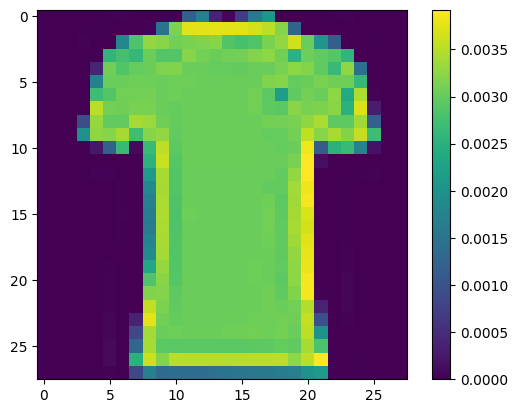

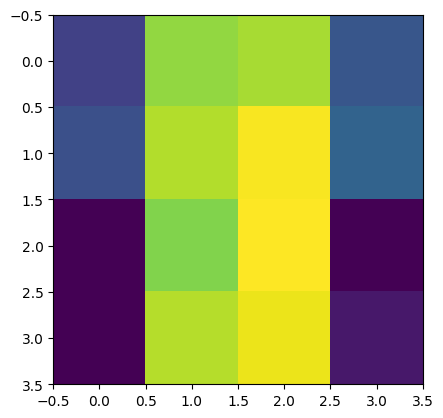

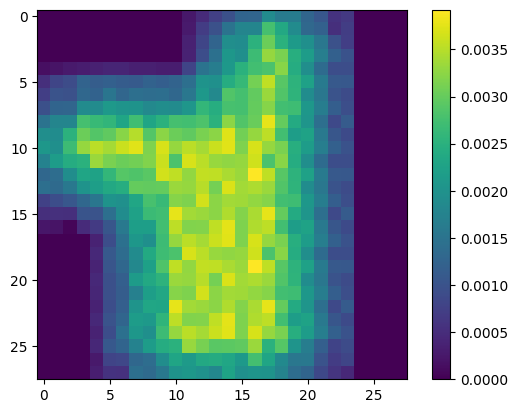

In [82]:
image = images[12]
plt.imshow(image)
plt.colorbar()
plt.show()
plt.imshow(reduze_size(image))
plt.show()
plt.imshow(decoder(simulate(encoder(image))))
plt.colorbar()

In [83]:
#how we grade your submission

n=len(dataset)
mse=0
gatecount=0

for image in images:
    #encode image into circuit
    circuit,image_re=run_part1(image)
    
    #count the number of 2qubit gates used
    gatecount+=count_gates(circuit)[2]
    
    #calculate mse
    mse+=image_mse(image,image_re)
    print(mse, end='\r')
    
#fidelity of reconstruction
f=1-mse
gatecount=gatecount/n

#score for part1 
print(f*(0.999**gatecount))

KeyboardInterrupt: 